# Optics Calculations

**G. Sterbini, CERN, BE-ABP-HSI**

## The CAS-19 

We will study a Cosy and Amusing proton Synchrotron with a flat bottom momentum of 1.9 GeV/c and a top momentup up to 19 GeV/c (let's call it **CAS-19**). 

We will use *cpymad* python package (https://github.com/hibtc/cpymad). To install it you can follow the instructions at https://codimd.web.cern.ch/s/rJ8M7oBQN.

Try to execute and to study step-by-step this notebook.

In [1]:
# as usual we will use MAD-X via python
from cpymad.madx import Madx

# standard packages and modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# standard configurations
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

# This functions will be used for the printing/plotting (nothing fundamental)
def showTunes():
    print(f'Q1 = {madx.table.summ.q1[0]:1.6}')
    print(f'Q2 = {madx.table.summ.q2[0]:1.6}')
    
def showChroma():
    print(f'DQ1 = {madx.table.summ.dq1[0]:1.6}')
    print(f'DQ2 = {madx.table.summ.dq2[0]:1.6}')

def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=1):
    aux=series
    ax.add_patch(
    patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color, alpha=alpha,lw=lw
    )
    )
    return;

## The CAS-19 beam parameters

In [2]:
def BeamParameters(pc_GeV, en_x_m=5e-6, en_y_m=5e-6, deltap_p=1e-3, verbose=True):
    Brho_Tm=3.3356*pc_GeV # Tm, beam rigidity (approx)
    E_0_GeV=0.9382720813 # GeV, rest mass energy
    E_tot_GeV=np.sqrt(pc_GeV**2+E_0_GeV**2)
    E_kin_GeV=E_tot_GeV-E_0_GeV
    gamma_r=E_tot_GeV/E_0_GeV
    beta_r=pc_GeV/E_tot_GeV
    eg_x_m=en_x_m/gamma_r/beta_r
    eg_y_m=en_y_m/gamma_r/beta_r


    if verbose:
        print(f'''Particle type: proton
        Beam momentum= {pc_GeV:2.3f} GeV/c
        normalized x-emittance= {en_x_m*1e6:2.3f} mm mrad
        normalized y-emittance= {en_y_m*1e6:2.3f} mm mrad
        deltap/p= {deltap_p} 
        -> Beam total energy= {E_tot_GeV:2.3f} GeV
        -> Beam kinetic energy= {E_kin_GeV:2.3f} GeV
        -> Beam rigidity= {Brho_Tm:2.3f} Tm
        -> relativistic beta= {beta_r:2.5f}
        -> relativistic gamma= {gamma_r:2.3f}
        -> geometrical x-emittance= {eg_x_m*1e6:2.3f} mm mrad
        -> geometrical y-emittance= {eg_y_m*1e6:2.3f} mm mrad
        ''')
    return {'pc_GeV': pc_GeV,'Brho_Tm': Brho_Tm,'E_0_GeV': E_0_GeV, 'E_tot_GeV':E_tot_GeV,
            'E_kin_GeV': E_kin_GeV, 'gamma_r': gamma_r, 'beta_r':beta_r, 'en_x_m':en_x_m, 'en_y_m':en_y_m,
            'eg_x_m':eg_x_m, 'eg_y_m':eg_y_m, 'deltap_p':deltap_p}

print('====== Injection Energy ======')
beamFB=BeamParameters(1.9, en_x_m=5e-6, en_y_m=5e-6, deltap_p=2e-3)

print('======== Top Energy ========')
beamFT=BeamParameters(19, en_x_m=5e-6, en_y_m=5e-6, deltap_p=2e-4)


====== Injection Energy ======
Particle type: proton
        Beam momentum= 1.900 GeV/c
        normalized x-emittance= 5.000 mm mrad
        normalized y-emittance= 5.000 mm mrad
        deltap/p= 0.002 
        -> Beam total energy= 2.119 GeV
        -> Beam kinetic energy= 1.181 GeV
        -> Beam rigidity= 6.338 Tm
        -> relativistic beta= 0.89663
        -> relativistic gamma= 2.258
        -> geometrical x-emittance= 2.469 mm mrad
        -> geometrical y-emittance= 2.469 mm mrad
        
======== Top Energy ========
Particle type: proton
        Beam momentum= 19.000 GeV/c
        normalized x-emittance= 5.000 mm mrad
        normalized y-emittance= 5.000 mm mrad
        deltap/p= 0.0002 
        -> Beam total energy= 19.023 GeV
        -> Beam kinetic energy= 18.085 GeV
        -> Beam rigidity= 63.376 Tm
        -> relativistic beta= 0.99878
        -> relativistic gamma= 20.275
        -> geometrical x-emittance= 0.247 mm mrad
        -> geometrical y-emittance= 0.247 m

## The CAS-19 lattice parameters

In [3]:
circum_m=500. # m, machine circumference
ncell=25.
l_quad_m=.5 # m
l_dip_m=3.5 # m
lcell_m=circum_m/ncell; # m

f_m=lcell_m/(2*np.sqrt(2)) # This will give pi/2 phase advance in thin lens approximation (no dipoles)

nQuadrupoles=2*ncell
nDipoles=4*ncell # four dipoles per cell
angleOfDipole_rad=2*np.pi/nDipoles 
fieldOfDipole_T= angleOfDipole_rad*beamFT['Brho_Tm']/l_dip_m
gradientOfQuadrupole_T_m= 1/f_m*beamFT['Brho_Tm']/l_quad_m
r_quadrupole_m= 0.065;
v_gap_dipole_m= 0.065;
h_gap_dipole_m= 0.09;


print(f'''Machine circumference: {circum_m} m
Number of FODO cells= {ncell}
Quadrupole length= {l_quad_m} m
Dipole length= {l_dip_m} m
Number of quadrupoles= {nQuadrupoles}
Number of dipoles= {nDipoles}
Quadrupole focal length= {f_m:2.3f} m
Radius of the quadrupole's aperture =  {r_quadrupole_m*1000} mm
Horizontal half-gap of the dipoles=  {h_gap_dipole_m*1000} mm
Vertical half-gap of the dipoles=  {v_gap_dipole_m*1000} mm

-> Length of FODO= {lcell_m} m
-> Angle of dipole = {angleOfDipole_rad*1000: 2.3f} mrad
-> Field of dipole = {fieldOfDipole_T: 2.3f} T
-> K1 of quadrupole = {1/f_m/l_quad_m: 2.3f} 1/m^2
-> Gradient of quadrupole = {gradientOfQuadrupole_T_m: 2.3f} T/m
-> Field on the tip of the quadrupole = {gradientOfQuadrupole_T_m*r_quadrupole_m: 2.3f} T
''')

Machine circumference: 500.0 m
Number of FODO cells= 25.0
Quadrupole length= 0.5 m
Dipole length= 3.5 m
Number of quadrupoles= 50.0
Number of dipoles= 100.0
Quadrupole focal length= 7.071 m
Radius of the quadrupole's aperture =  65.0 mm
Horizontal half-gap of the dipoles=  90.0 mm
Vertical half-gap of the dipoles=  65.0 mm

-> Length of FODO= 20.0 m
-> Angle of dipole =  62.832 mrad
-> Field of dipole =  1.138 T
-> K1 of quadrupole =  0.283 1/m^2
-> Gradient of quadrupole =  17.926 T/m
-> Field on the tip of the quadrupole =  1.165 T



In [4]:
madx = Madx()



  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.05.10               +
  + Execution date: 2019.06.17 14:25:38      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [4]:
madx = Madx(stdout=False)
madx.input(f'''
circum={circum_m};
ncell ={ncell}; !Number of cells 
lcell = {lcell_m};
lq = {l_quad_m}; !Length of a quadrupole
ldip = {l_dip_m};
!element definitions;
!define bending magnet as multipole 
!we have 4 bending magnets per cell
!mb:multipole,knl={{2.0*pi/(4*ncell)}};

mb: sbend, l=ldip, angle=2.0*pi/(4*ncell), apertype=ellipse, aperture= {{{h_gap_dipole_m}, {v_gap_dipole_m}}};

f={f_m};

!define quadrupoles as multipoles 
qf: multipole,knl:={{0,1/f+qtrim_f}}; 
qd: multipole,knl:={{0,-1/f+qtrim_d}};
qf: quadrupole, l=lq, K1:=1/f/lq  + qtrim_f/lq, apertype=ellipse, aperture= {{{r_quadrupole_m}, {r_quadrupole_m}}}; 
qd: quadrupole, l=lq, K1:=-1/f/lq + qtrim_d/lq, apertype=ellipse, aperture= {{{r_quadrupole_m}, {r_quadrupole_m}}};

!define the sextupoles as multipole
lsex = 0.00001; ! dummy length, only used in the sequence;

!ATTENTION: must use knl:= and NOT knl= to match later! 
msf: multipole, knl:={{0,0,ksf}};
msd: multipole, knl:={{0,0,ksd}};

!sequence declaration;
!I switch off the warning to limit the output
!use this option with moderation (I switch it back in after the sequence)
option, warn=false;
cas19: sequence, refer=centre, l=circum;
   start_machine: marker, at = 0;
   n = 1;
   while (n < ncell+1) {{
    qf: qf,   at=(n-1)*lcell+ lq/2.0;
    msf: msf, at=(n-1)*lcell + lsex/2.0+lq/1.0;
    mb: mb,   at=(n-1)*lcell + 0.15*lcell;
    mb: mb,   at=(n-1)*lcell + 0.35*lcell;
    qd: qd,   at=(n-1)*lcell + 0.50*lcell+ lq/2.0;
    msd: msd, at=(n-1)*lcell + 0.50*lcell + lsex/2.0+lq/1.0;
    mb: mb,   at=(n-1)*lcell + 0.65*lcell;
    mb: mb,   at=(n-1)*lcell + 0.85*lcell;
    n = n + 1;
}}
end_machine: marker at=circum;
endsequence;
option, warn=true;

!define the beam and its properties
beam, particle = proton, sequence=cas19, energy = {beamFB['E_tot_GeV']}, exn={beamFB['en_x_m']}, eyn={beamFB['en_y_m']},sige={beamFB['en_y_m']};

use, sequence=cas19;
select, flag=twiss, column=apertype, aper_1, aper_2;

ksf=0;
ksd=0;
twiss;
''')
myTwiss=madx.table.twiss.dframe()
showTunes()

Q1 = 6.26177
Q2 = 6.11714


**Comments**: in thin lens approximations and neglecting the weak focusing of the dipoles we expected Q1 = 6.25 and Q2 = 6.25.

In [6]:
# option to see the value of the optics functiona also inside the elements
madx.input('''
select,flag=interpolate, class=drift, slice=4, range=#s/#e;
select,flag=interpolate, class=quadrupole, slice=8, range=#s/#e;
select,flag=interpolate, class=sbend, slice=10, range=#s/#e;
twiss;
'''
)
myTwissHR=madx.table.twiss.dframe() # HR stands for High Resolution in the s-direction
twissBeforeQCorrection=myTwissHR
summBeforeQCorrection=madx.table.summ

## CAS-19 lattice

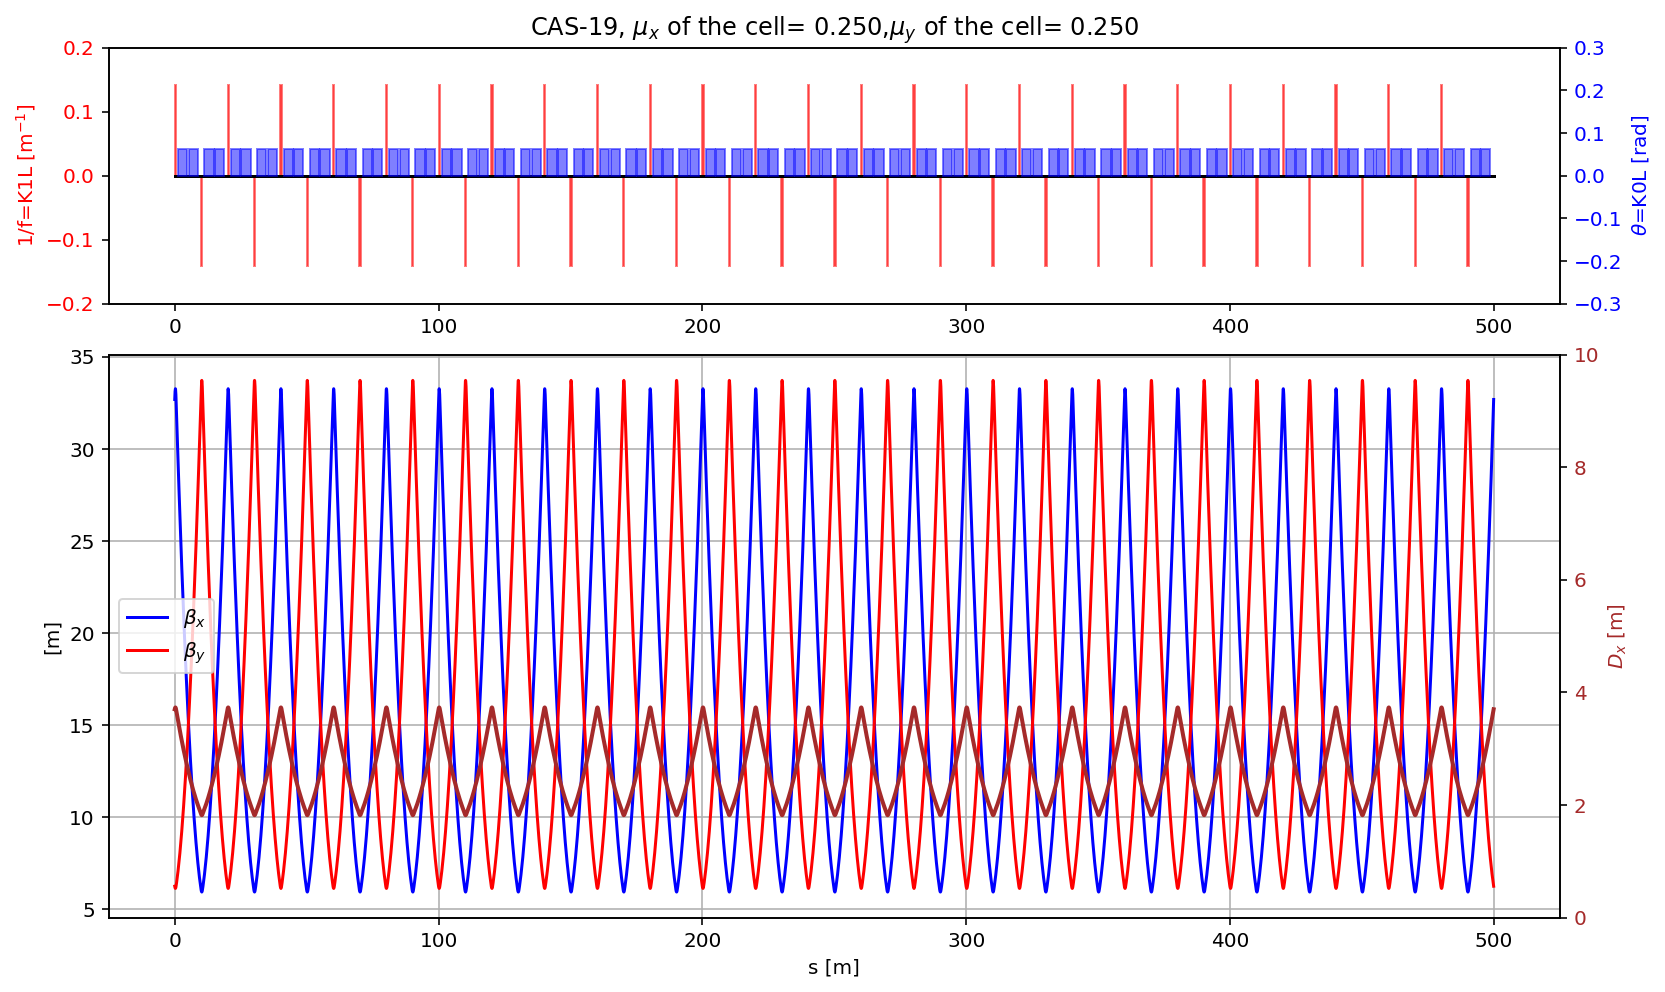

In [7]:
# just plotting
fig = plt.figure(figsize=(13,8))
ax1=plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=1)
plt.plot(myTwiss['s'],0*myTwiss['s'],'k')

DF=myTwiss[(myTwiss['keyword']=='quadrupole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')
    
DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k1l, v_offset=aux.k1l/2, color='r')

    color = 'red'
ax1.set_ylabel('1/f=K1L [m$^{-1}$]', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ylim(-.2,.2)
plt.title(f'CAS-19, $\\mu_x$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f},\
$\\mu_y$ of the cell={madx.table.summ.Q1[0]/ncell: 2.3f}')
ax2 = ax1.twinx()

color = 'blue'
ax2.set_ylabel('$\\theta$=K0L [rad]', color=color)
ax2.tick_params(axis='y', labelcolor=color)

DF=myTwiss[(myTwiss['keyword']=='multipole')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.k2l, v_offset=aux.k2l/2, color='y')

DF=myTwiss[(myTwiss['keyword']=='sbend')]
for i in range(len(DF)):
    aux=DF.iloc[i]
    plotLatticeSeries(plt.gca(),aux, height=aux.angle, v_offset=aux.angle/2, color='b')

    
plt.ylim(-.3,.3)

axbeta=plt.subplot2grid((3,3), (1,0), colspan=3, rowspan=2,sharex=ax1)

plt.plot(myTwissHR['s'],myTwissHR['betx'],'b', label='$\\beta_x$')
plt.plot(myTwissHR['s'],myTwissHR['bety'],'r', label='$\\beta_y$')
plt.legend(loc='best')
plt.ylabel('[m]')
plt.xlabel('s [m]')
plt.grid()

ax3 = plt.gca().twinx() 
plt.plot(myTwissHR['s'],myTwissHR['dx'],'brown', label='$D_x$', lw=2)
ax3.set_ylabel('$D_x$ [m]', color='brown')
ax3.tick_params(axis='y', labelcolor='brown')
plt.ylim(0, 10);

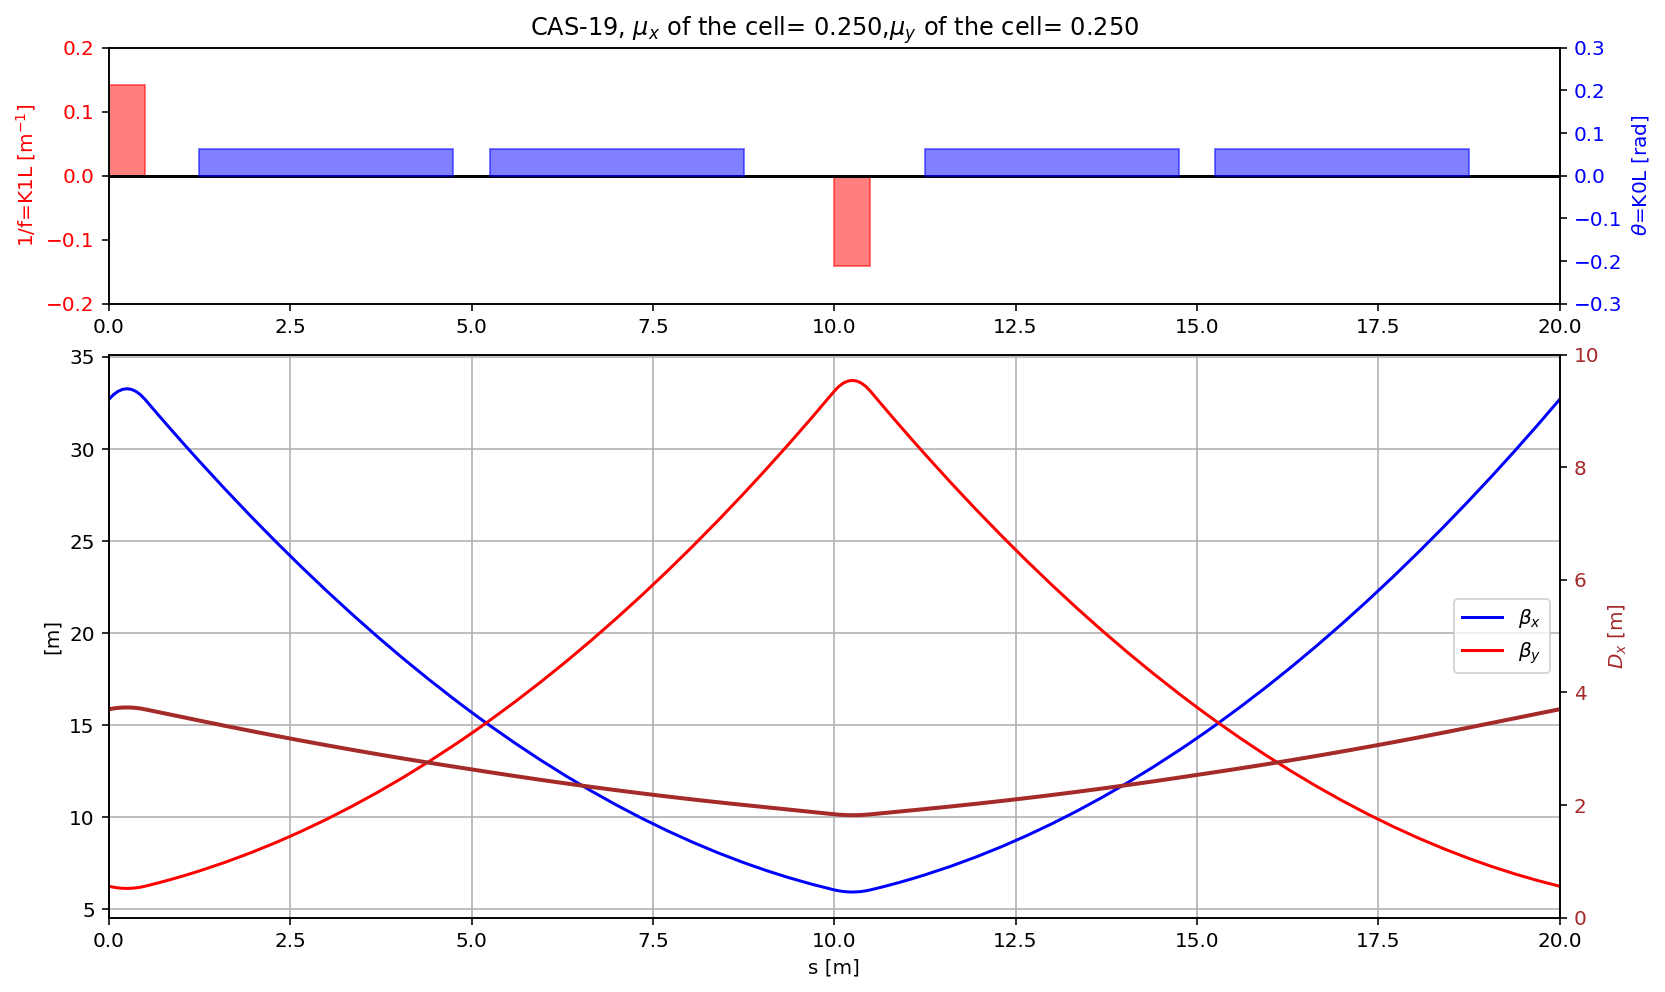

In [8]:
fig.gca().set_xlim(0, lcell_m)
display(fig)

**Comments**: we expected a $\beta_{max}$ of about twice the FODO cell ( $\beta_{max}\approx 40$ m).

## The machine tunnel
After having verified the machine stability, let us check the machine geometry.

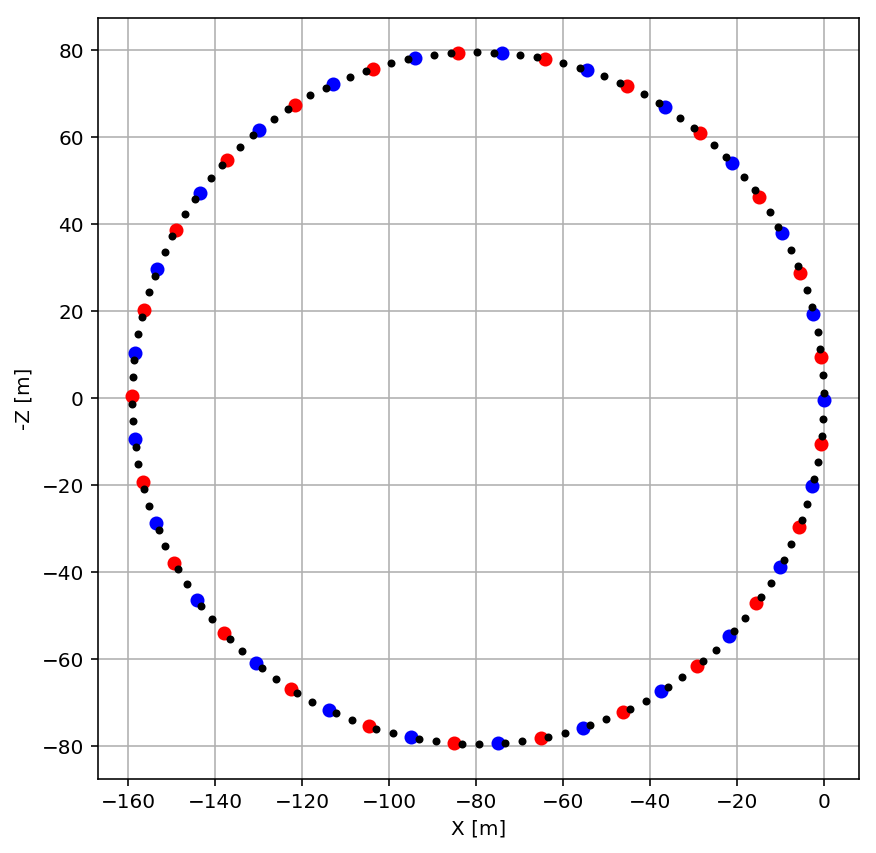

In [9]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()

qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]


plt.figure(figsize=(7,7))
plt.plot(qfSurvey.x,-qfSurvey.z,'ob')
plt.plot(qdSurvey.x,-qdSurvey.z,'or')
plt.plot(mbSurvey.x,-mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('-Z [m]')
plt.grid()

## Beam envelopes and machine aperture
As third step, we verify the machine aperture 

In [10]:
def plotAperture(beam):
    pc=beam['pc_GeV']
    madx.input('twiss;')

    myTwissHR['betatronicEnvelope_x']=np.sqrt(myTwissHR['betx']*beam['eg_y_m'])
    myTwissHR['betatronicEnvelope_y']=np.sqrt(myTwissHR['bety']*beam['eg_y_m'])
    myTwissHR['dispersiveEnvelope_x']=myTwissHR['dx']*beam['deltap_p']
    myTwissHR['dispersiveEnvelope_y']=myTwissHR['dy']*beam['deltap_p']
    myTwissHR['envelope_x']=np.sqrt(myTwissHR['betatronicEnvelope_x']**2+(myTwissHR['dx']*beam['deltap_p'])**2)
    myTwissHR['envelope_y']=np.sqrt(myTwissHR['betatronicEnvelope_y']**2+(myTwissHR['dy']*beam['deltap_p'])**2)

    plt.plot(myTwissHR['s'],myTwissHR['envelope_x'],'b')
    plt.plot(myTwissHR['s'],-myTwissHR['envelope_x'],'b')


    plt.fill_between(myTwissHR['s'], myTwissHR['envelope_x'], -myTwissHR['envelope_x'],color='b',alpha=.25)
    plt.fill_between(myTwissHR['s'], 3*myTwissHR['envelope_x'], -3*myTwissHR['envelope_x'],color='b',alpha=.25)

    plt.xlim(0,lcell_m)
    plt.ylabel('x [m]')
    plt.xlabel('s [m]')

    aux=myTwissHR[myTwissHR['apertype']=='ellipse']
    plt.fill_between(aux['s'], aux['aper_1'], aux['aper_1']*100,color='k',alpha=.5)
    plt.fill_between(aux['s'], -aux['aper_1'], -aux['aper_1']*100,color='k',alpha=.5)

    plt.plot(aux['s'],aux['aper_1'],'k.-')
    plt.plot(aux['s'],-aux['aper_1'],'k.-')

    plt.xlim(0, lcell_m)
    plt.ylim(-.12, .12)
    plt.title(f'Horizontal aperture at {pc} GeV/c')
    ########################################################################
    plt.figure()

    plt.plot(myTwissHR['s'],myTwissHR['envelope_y'],'r')
    plt.plot(myTwissHR['s'],-myTwissHR['envelope_y'],'r')


    plt.fill_between(myTwissHR['s'], myTwissHR['envelope_y'], -myTwissHR['envelope_y'],color='r',alpha=.25)
    plt.fill_between(myTwissHR['s'], myTwissHR['envelope_y'], -myTwissHR['envelope_y'],color='r',alpha=.25)
    plt.fill_between(myTwissHR['s'], 3*myTwissHR['envelope_y'], -3*myTwissHR['envelope_y'],color='r',alpha=.25)
    plt.fill_between(myTwissHR['s'], 3*myTwissHR['envelope_y'], -3*myTwissHR['envelope_y'],color='r',alpha=.25)

    plt.xlim(0,lcell_m)
    plt.ylabel('y [m]')
    plt.xlabel('s [m]')

    aux=myTwissHR[myTwissHR['apertype']=='ellipse']
    plt.fill_between(aux['s'], aux['aper_2'], aux['aper_2']*100,color='k',alpha=.5)
    plt.fill_between(aux['s'], -aux['aper_2'], -aux['aper_2']*100,color='k',alpha=.5)

    plt.plot(aux['s'],aux['aper_2'],'k.-')
    plt.plot(aux['s'],-aux['aper_2'],'k.-')

    plt.xlim(0, lcell_m)
    plt.ylim(-.12, .12)
    plt.title(f'Vertical aperture at {pc} GeV/c')

    plt.figure()
    plt.plot(aux['s'],aux['aper_1']/aux['envelope_x'],'.-b', label='Horizontal plane')
    plt.plot(aux['s'],aux['aper_2']/aux['envelope_y'],'.-r', label='Vertical plane')

    plt.xlim(0, lcell_m)
    plt.grid(True)
    plt.ylabel('n1')
    plt.xlabel('s [m]')
    plt.legend(loc='best')
    plt.title(f'Stay-clear envelope at {pc} GeV/c')


#### Aperture at injection

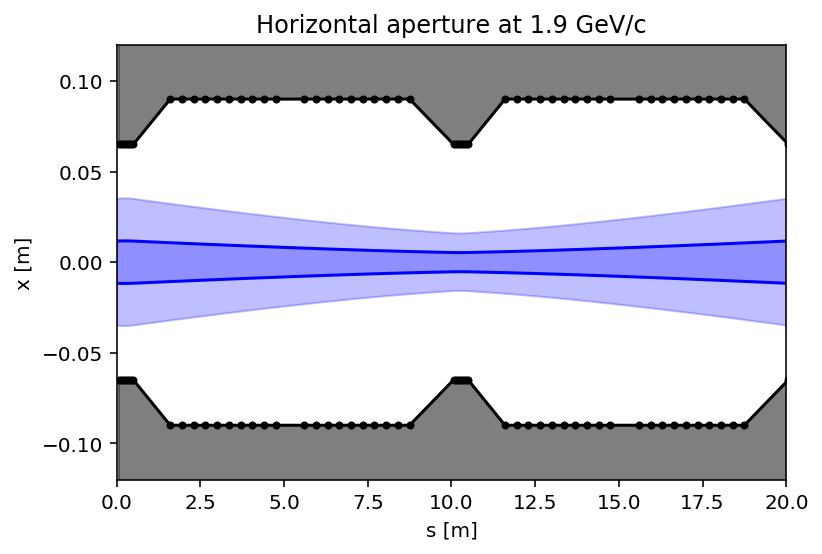

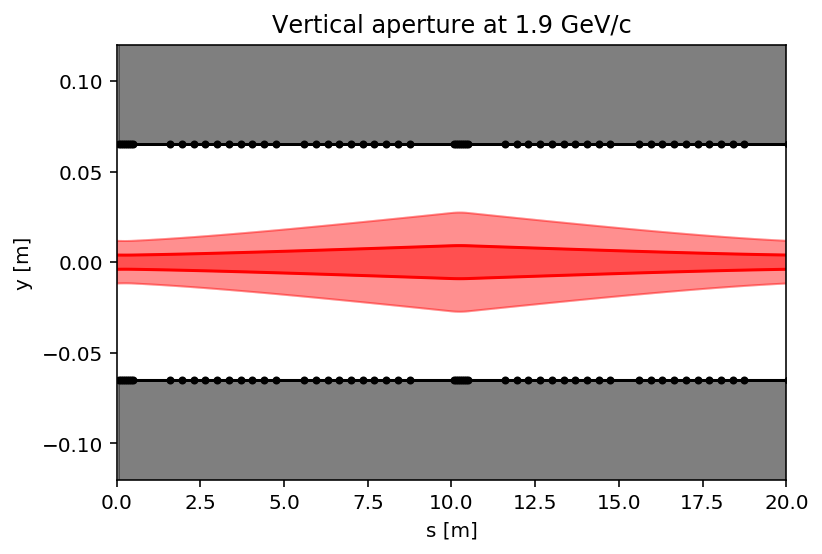

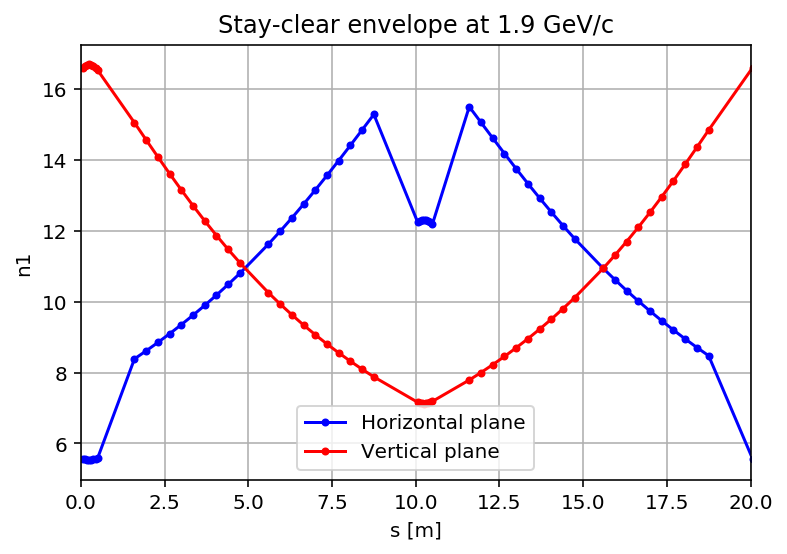

In [11]:
plotAperture(beamFB)

#### Aperture at top energy

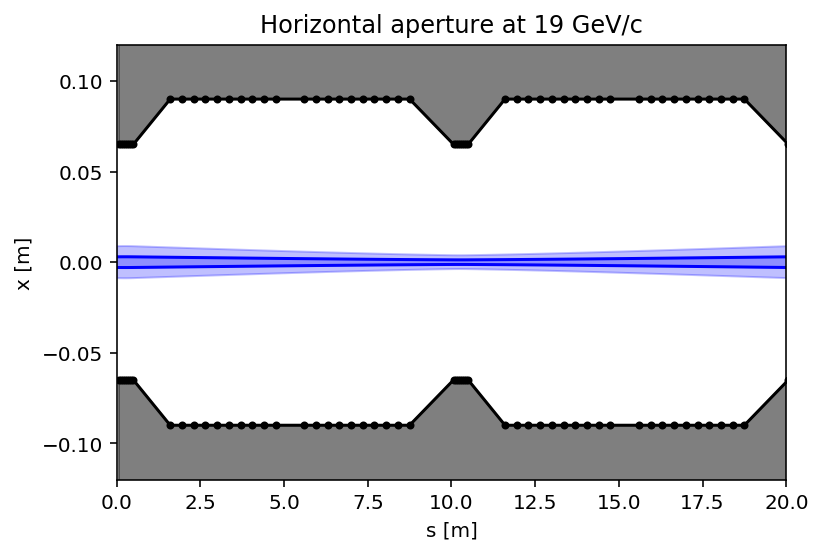

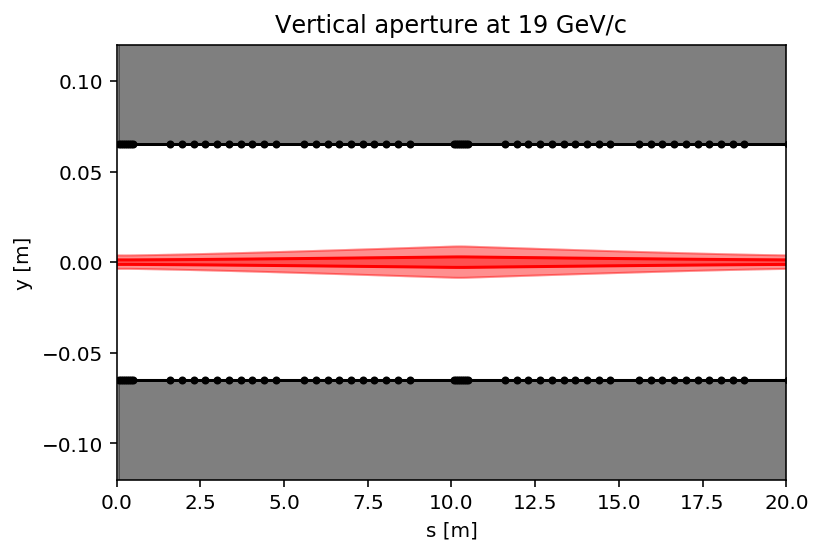

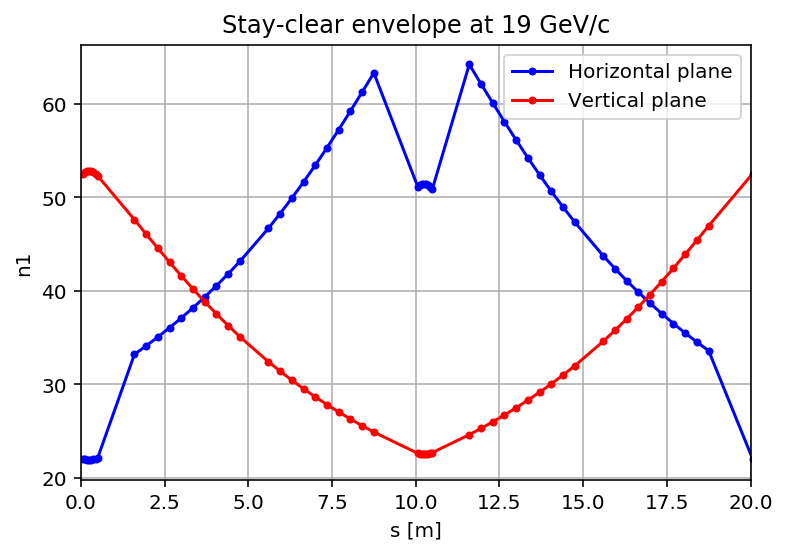

In [12]:
plotAperture(beamFT)

# Tune control
We will plot the current working point on the tune diagram.

In [13]:
Q1=summBeforeQCorrection.q1[0]
Q2=summBeforeQCorrection.q2[0]
showTunes()

Q1 = 6.26177
Q2 = 6.11714


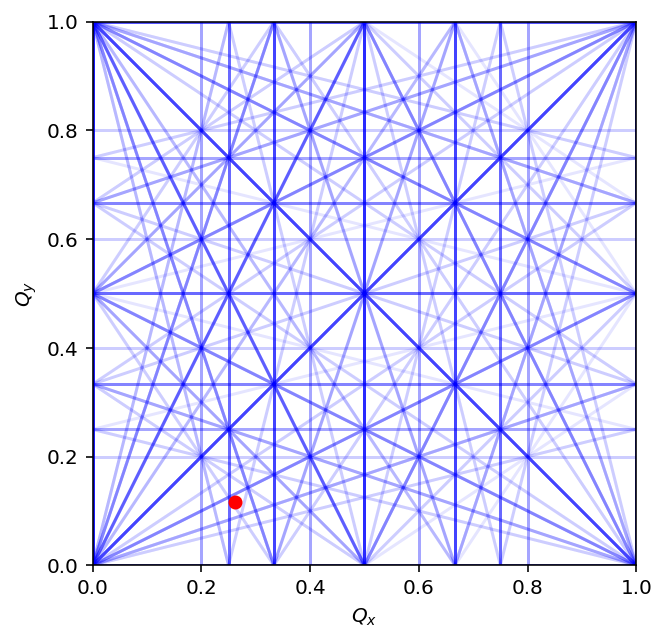

In [14]:
# From R. Tomas
# http://cas.web.cern.ch/sites/cas.web.cern.ch/files/lectures/thessaloniki-2018/slidesbeamer.pdf
def Farey (n):
    '''Return the n-th Farey sequence, ascending.''' 
    seq = [[0 , 1]]
    a, b, c, d = 0, 1, 1, n
    while c <= n:
        k = int( (n + b)/d )
        a, b, c, d = c, d, k*c-a, k*d-b
        seq.append([a , b])
    return seq

def plotTuneDiagram():
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes()
    plt.ylim((0,1))
    plt.xlim((0,1))
    x=np.linspace(0,1,1000)
    for i in range(1,6):
        FN=Farey(i) 
        for f in FN:
            h,k=f #Node h/k on the axes
            for sf in FN:
                p,q=sf
                c=float(p*h)
                a=float(k*p) #ResonancelineaQx+bQy=clinkedtop/q
                b=float(q-k*p)
                if a>0:
                    plt.plot(x,c/a-x*b/a,'b',alpha=.1)
                    plt.plot(x,c/a+x*b/a,'b',alpha=.1)
                    plt.plot(c/a-x*b/a,x,'b',alpha=.1)
                    plt.plot(c/a+x*b/a,x,'b',alpha=.1)
                    plt.plot(c/a-x*b/a,1-x,'b',alpha=.1)
                    plt.plot(c/a+x*b/a,1-x,'b',alpha=.1)
                if q==k and p==1: #FNelementsbelow1/k
                    break

    plt.axis('square')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('$Q_x$')
    plt.ylabel('$Q_y$');

plotTuneDiagram()
plt.plot(Q1-np.floor(Q1),Q2-np.floor(Q2),'or');

Let us start assuming simple on-momentum tune shift and considering two Q-trim quadrupole in $s_1$ and $s_2$. Then the linear response of tune correction $(\Delta Q_x,~\Delta Q_y)^T$ with respect to the quadrupole integrated gradients $(k1l(s_1),~k1l(s_2))^T$ is 

\begin{equation}
\begin{pmatrix}
\Delta Q_x \\ 
\Delta Q_y
\end{pmatrix}=\underbrace{\frac{1}{4\pi}
\begin{pmatrix}
\beta_x(s_1) & \beta_x(s_2)   \\ 
-\beta_y(s_1) & -\beta_y(s_2) 
\end{pmatrix}}_{R_{k1l\rightarrow\Delta Q}}
\begin{pmatrix}
k1l(s_1) \\ 
k1l(s_2)
\end{pmatrix}.
\end{equation}

By inverting this problem we can compute the integrated gradient needed (the currents in the trim quadrupoles). I assume a target of Q1=6.14 and Q2=6.17.

In [7]:
import numpy as np
q1_target=6.14
q2_target=6.17
delta_q1=q1_target-summBeforeQCorrection.q1[0]
delta_q2=q2_target-summBeforeQCorrection.q2[0]
aux=twissBeforeQCorrection[twissBeforeQCorrection['name']=='qf:1']
bx1=aux['betx'].values[0]
by1=aux['bety'].values[0]

aux=twissBeforeQCorrection[twissBeforeQCorrection['name']=='qd:1']
bx2=aux['betx'].values[0]
by2=aux['bety'].values[0]

####### Solution of the linear problem #######
M=np.array([[bx1, bx2],[-by1, -by2]])/4./np.pi
mySolution=np.linalg.inv(M)@np.array([[delta_q1],[delta_q2]])
print('=======================================')
print('This is the solution our matrix of the\nintegrated quadrupole strength:')
display(mySolution)
print('=======================================')
# Clearly it has to be divided by the number of the cells, since the correction it is applied not in for lattice cell
# but in all.

This is the solution our matrix of the
integrated quadrupole strength:


array([[-0.04432669],
       [-0.01166028]])

In [16]:
# implementing in MAD-X the found solution
madx.input(f'''
! FROM the analytical approach
qtrim_f={mySolution[0][0]}/ncell;
qtrim_d={mySolution[1][0]}/ncell;
twiss;
''');
twissAfterQCorrection=madx.table.twiss.dframe()
summAfterQCorrection=madx.table.summ.dframe()
showTunes()

Q1 = 6.13936
Q2 = 6.16985


**Comments**: the correction is very close to the target.

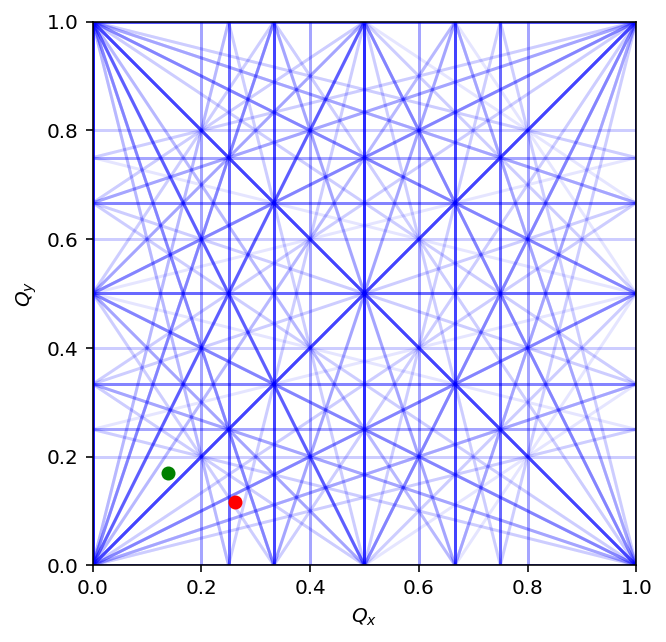

In [17]:
plotTuneDiagram()
plt.plot(Q1-np.floor(Q1),Q2-np.floor(Q2),'or');
newQ1=summAfterQCorrection.q1[0]
newQ2=summAfterQCorrection.q2[0]
plt.plot(newQ1-np.floor(newQ1),newQ2-np.floor(newQ2),'og');

### $\beta$-beating from Q-correction
We could not be exaclty on the target tunes since the model on which we based the correction formula is perturbative. It does not take into account the $\beta$-beating induced by the trim quadrupoles. 

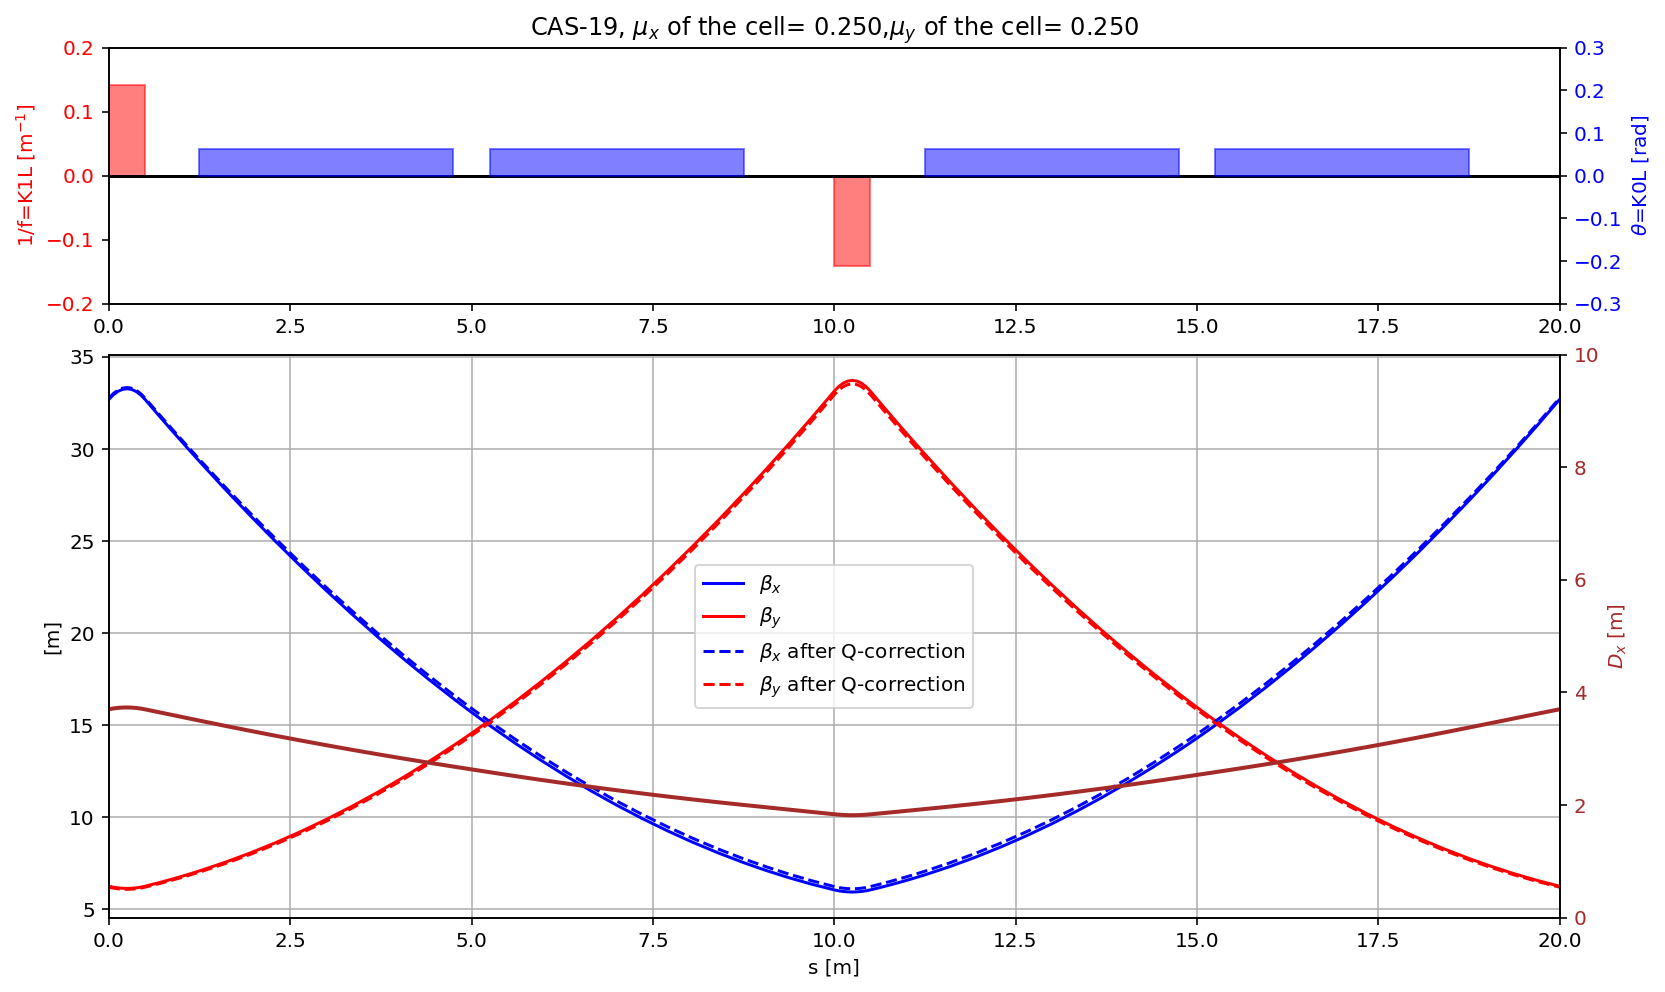

In [18]:
fig.gca().set_xlim(0, lcell_m)
axbeta.plot(twissAfterQCorrection['s'],twissAfterQCorrection['betx'],'b--', label='$\\beta_x$ after Q-correction')
axbeta.plot(twissAfterQCorrection['s'],twissAfterQCorrection['bety'],'r--', label='$\\beta_y$ after Q-correction')
axbeta.legend(loc='best')
display(fig)

For this reason the final tune is not (exactly) the programmed one. To refine the tune values we can match them with MAD-X direclty.

In [8]:
# The MAD-X matching 
madx.input(f'''
! Matching
match, sequence=cas19;
  vary,name=qtrim_f, step=0.00001;
  vary,name=qtrim_d, step=0.00001;
  global,Q1={q1_target};
  global,Q2={q2_target};
  lmdif, calls=10, tolerance=1.0e-21;
endmatch;

!execute the TWISS command 
twiss;
''')
showTunes()

Q1 = 6.14
Q2 = 6.17


Indeed with MAD-X the correction is much more accurate (**Q1=6.14** and **Q2=6.17**).

### Can you determing by a numerical experiment (tracking) the machine tune?
To know more about the the tracking module in MAD-X see Chapter 29 of the MAD-X User Guide,
http://madx.web.cern.ch/madx/webguide/manual.html#Ch2)

Before tracking with the **TRACK** environment, one has to transform the lattice in thin elements via the **MAKETHIN** command (see http://madx.web.cern.ch/madx/webguide/manual.html#Ch23). 

In [12]:
# I use a very high number of slices such to have the thin machine as close as possible
# to the thick one
madx.input('''
select, flag=makethin, class=quadrupole, slice=8;
select, flag=makethin, class=sbend, slice=10;
makethin, sequence=cas19;
use, sequence=cas19;
twiss;
''');
showTunes()

Q1 = 6.14
Q2 = 6.16999


Please note that the **makethin** changed (slightly) the tunes (therefore) the optics. We will repeat the matching to go back to the target working point.

In [21]:
madx.input(f'''
! Matching
match, sequence=cas19;
  vary,name=qtrim_f, step=0.00001;
  vary,name=qtrim_d, step=0.00001;
  global,Q1={q1_target};
  global,Q2={q2_target};
  lmdif, calls=10, tolerance=1.0e-21;
endmatch;

!execute the TWISS command 
twiss;
''');
showTunes()

Q1 = 6.14
Q2 = 6.17


In [22]:
# We track a particle with 0.1 mm offset in the two planes
myString='''
TRACK;
START, X=0.0001, PX=0, Y=0.0001, PY=0, T=0, PT=0;
RUN, TURNS=1023;
ENDTRACK;
'''
madx.input(myString);

In [22]:
# here you are the available tables of your MAD-X instance
list(madx.table)

['summ', 'twiss', 'survey', 'tracksumm', 'track.obs0001.p0001']

In [23]:
# track.obs0001.p0001 contains the tracking information
myParticle=madx.table['track.obs0001.p0001'].dframe()
myParticle.head()

,number,turn,x,px,y,py,t,pt,s,e
#e,1.0,0.0,0.000100,0.000000,0.000100,0.000000,0.000000e+00,0.0,0.0,2.119046
#e,1.0,1.0,-0.000113,-0.000015,0.000089,-0.000017,4.062102e-08,0.0,0.0,2.119046
#e,1.0,2.0,-0.000244,-0.000019,-0.000014,-0.000017,1.920537e-05,0.0,0.0,2.119046
#e,1.0,3.0,-0.000198,-0.000009,-0.000103,0.000001,4.351850e-05,0.0,0.0,2.119046
#e,1.0,4.0,-0.000008,0.000007,-0.000085,0.000018,5.527163e-05,0.0,0.0,2.119046


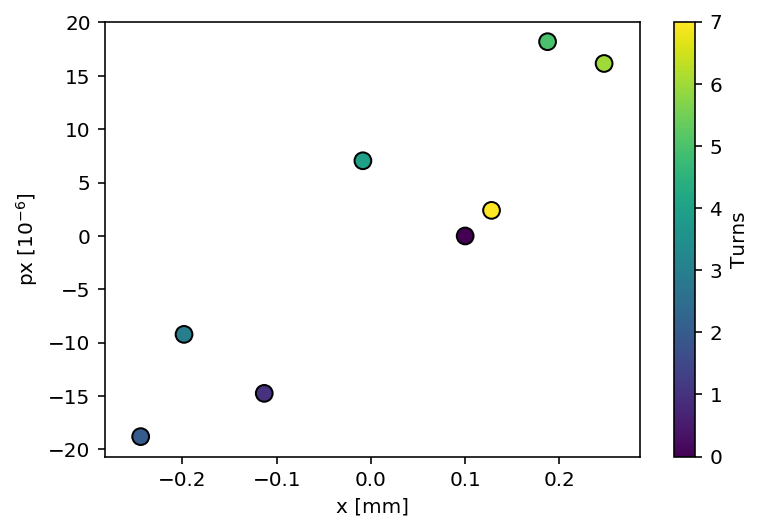

In [24]:
# I plot the first 8 turns in the x-plane
myParticle100=myParticle[0:8]
plt.scatter(myParticle100['x']*1000,myParticle100['px']*1e6,c=myParticle100['turn'],s=70, edgecolor='black')
myColorbar=plt.colorbar()
myColorbar.set_label('Turns')
plt.xlabel('x [mm]')
plt.ylabel('px [$10^{-6}$]');
# particle rotate clock-wise in the transverse plane

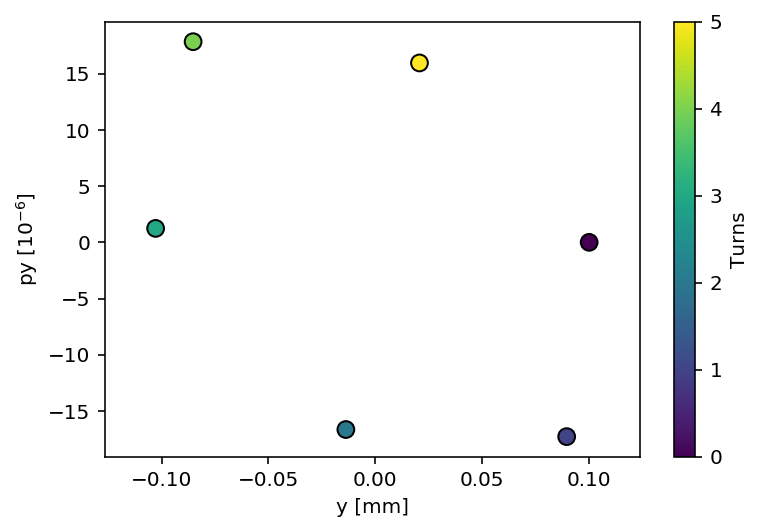

In [25]:
# I plot the first 6 turns in the x-plane
myParticle100=myParticle[0:6]
plt.scatter(myParticle100['y']*1000,myParticle100['py']*1e6,c=myParticle100['turn'],s=70, edgecolor='black')
myColorbar=plt.colorbar()
myColorbar.set_label('Turns')
plt.xlabel('y [mm]')
plt.ylabel('py [$10^{-6}$]');
# particle rotate clock-wise in the transverse plane

#### Plotting on the normalized phase-space

Remembering that 
\begin{equation}
\bar{P}={\begin{pmatrix}
 \sqrt{\beta} &        0\\
-\frac{\alpha}{\sqrt{\beta}} &  \frac{1}{\sqrt{\beta}}
\end{pmatrix}}
\nonumber
\end{equation}
and that the relation between real phase-space, $X$, and  normalized phase space, $\bar{X}$, is
\begin{equation}
\bar{X}=\bar{P}^{-1} X
\end{equation}
one can transform the previous plots in normalized phase-space.


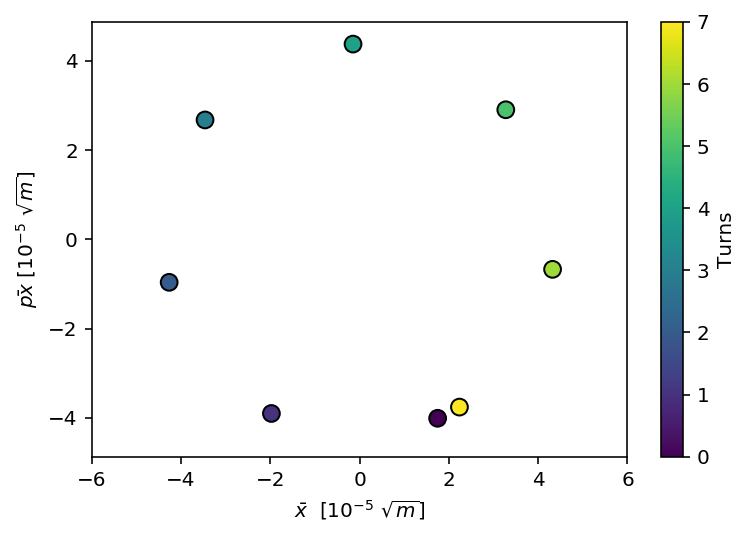

In [26]:
myParticle100=myParticle[0:8]
beta=madx.table.twiss.betx[0]
alpha=madx.table.twiss.alfx[0]
P=np.array([[np.sqrt(beta), 0],[-alpha/np.sqrt(beta), 1/np.sqrt(beta)]])
X= np.array([myParticle100['x'].values,myParticle100['px'].values])
barX=np.linalg.inv(P)@X
plt.scatter(barX[0,:]*1e5,barX[1,:]*1e5,c=myParticle100['turn'],s=70, edgecolor='black')
myColorbar=plt.colorbar()
myColorbar.set_label('Turns')
plt.axis('equal');
plt.ylim([-6,6])
plt.xlim([-6,6])
plt.xlabel('$\\bar{x}$  [$10^{-5}\ \\sqrt{m}$]')
plt.ylabel('$\\bar{px}$ [$10^{-5}\ \\sqrt{m}$]');

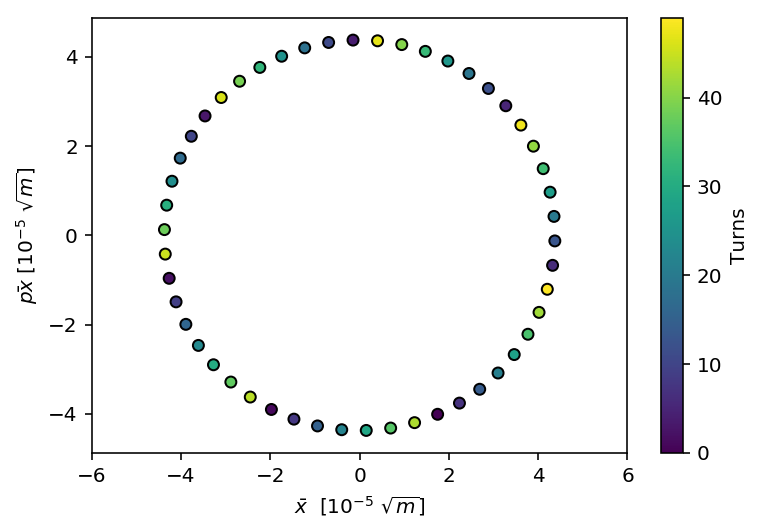

In [27]:
# plotting all the turns
myParticle100=myParticle[0:50]

beta=madx.table.twiss.betx[0]
alpha=madx.table.twiss.alfx[0]
P=np.array([[np.sqrt(beta), 0],[-alpha/np.sqrt(beta), 1/np.sqrt(beta)]])
X= np.array([myParticle100['x'].values,myParticle100['px'].values])
barX=np.linalg.inv(P)@X
plt.scatter(barX[0,:]*1e5,barX[1,:]*1e5,c=myParticle100['turn'],s=30, edgecolor='black')
myColorbar=plt.colorbar()
myColorbar.set_label('Turns')
plt.axis('equal');
plt.ylim([-6,6])
plt.xlim([-6,6])
plt.xlabel('$\\bar{x}$  [$10^{-5}\ \\sqrt{m}$]')
plt.ylabel('$\\bar{px}$ [$10^{-5}\ \\sqrt{m}$]');
# One cas see only the last 50 turns.

### Tune determination
To determine the tune one can evaluate the maximum of the amplitude of the FFT of x (or px).

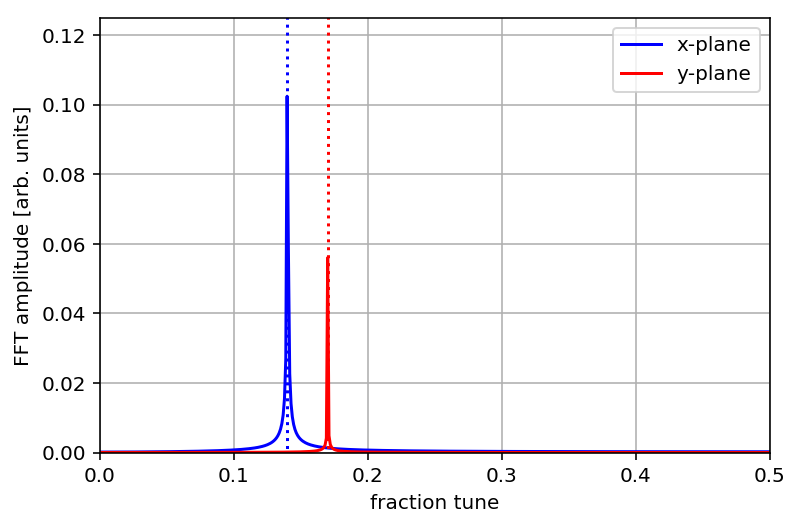

In [28]:
myAmplitude=np.abs(np.fft.fft(myParticle['x']));
myTunes=np.linspace(0,1,len(myParticle))
plt.plot(myTunes,myAmplitude,'b',label='x-plane')
plt.xlim([0,0.5])
plt.grid()
myAmplitude=np.abs(np.fft.fft(myParticle['y']));
myTunes=np.linspace(0,1,len(myParticle))
plt.plot(myTunes,myAmplitude,'r',label='y-plane')
plt.plot([q1_target-np.round(q1_target),q1_target-np.round(q1_target)],[-10,10],':b')
plt.plot([q2_target-np.round(q2_target),q2_target-np.round(q2_target)],[-10,10],':r')
plt.ylim([0,.125])
plt.ylabel('FFT amplitude [arb. units]')
plt.xlabel('fraction tune')
plt.legend(loc='best');

In general we can profit, in our frequency analysis, of the fact that our system in most of cases presents  well separated harmonic oscillations. These algorithms are based on time (e.g., *NAFF: Icarus 88, Issue 2, 1990*) or frequency interpolations (e.g., *SUSSIX: CERN SL/Note 98-017, 1998*). We are going to use the pyNAFF package (see https://pypi.org/project/PyNAFF/) that is implementing the NAFF algorithm.

In [29]:
# comparing PyNAFF with a regular FFT
import PyNAFF as pnf
import numpy as np

t = np.linspace(1, 1024, num=1024, endpoint=True)
signal = myParticle['x'].values
# outputs an array of arrays for each frequency. Each sub-array includes:
# [order of harmonic, frequency, Amplitude, Re{Amplitude}, Im{Amplitude]

myListNAFF=[]
myListFFT=[]
for i in np.arange(20,1025):
    myListNAFF.append(pnf.naff(signal, i, 1, 0 , False)[0][1])
    myAmplitude=np.abs(np.fft.fft(myParticle['x'][0:i]));
    myTunes=np.linspace(0,1,i)
    myListFFT.append(np.min(myTunes[myAmplitude==np.max(myAmplitude)]))

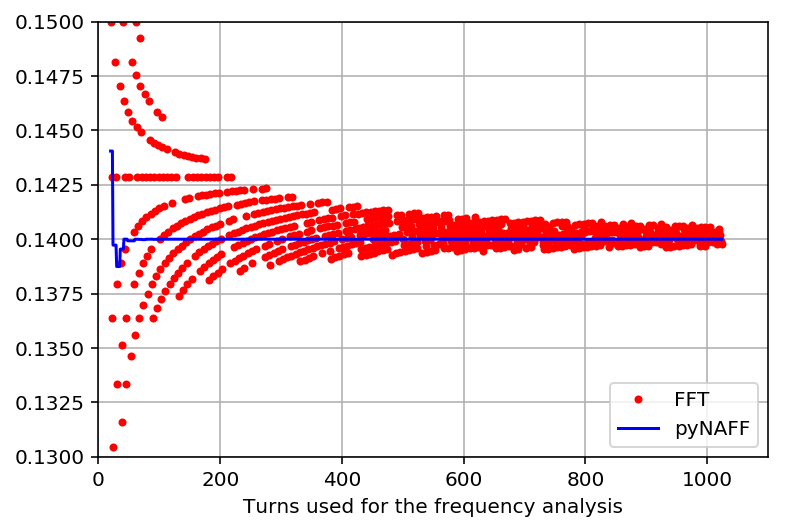

In [30]:
myFig=plt.figure()
plt.plot(np.arange(20,1025),myListFFT,'.r',label='FFT')
plt.plot(np.arange(20,1025),myListNAFF,'b',label='pyNAFF')
#plt.plot(np.arange(0,2000),madx.table.summ.Q1[0]+np.arange(0,2000)*0-6,'k',label='exepected')
plt.grid()
plt.ylim(.13,.15)
plt.xlim(0,1100)
plt.xlabel('Turns used for the frequency analysis')
plt.legend(loc='best')

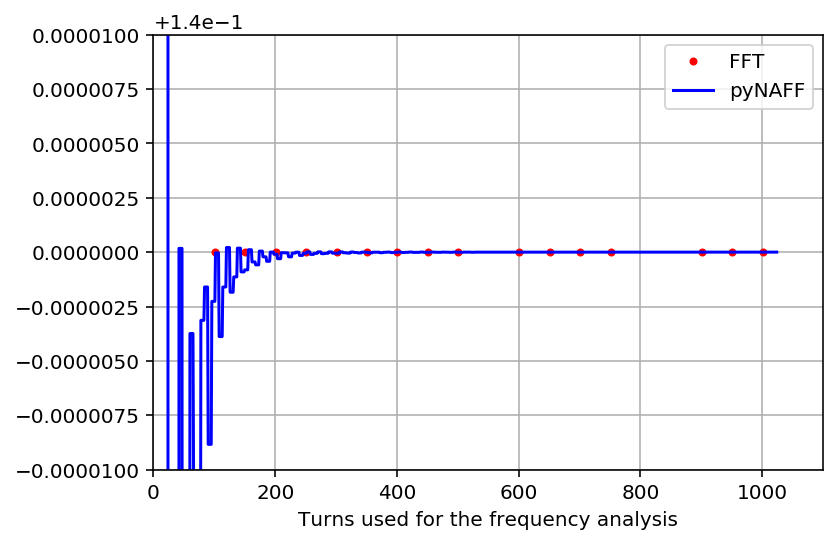

In [31]:
# a zoom on the convergence
myFig.gca().set_ylim(.14-1e-5,.14+1e-5)
display(myFig)

We obtained a very good convergece already with 200 tunrs (no noise is included).

## Chromaticity
We are going now to study the chromatic propertis of CAS-19 lattice.
Notice that in MAD-X, ${\rm PT}$ substitutes ${\rm DELTAP}$ as longitudinal variable. Dispersive and chromatic functions are hence derivatives with respect to PT. And since 
\begin{equation}
{\rm PT}=\beta_r* {\rm DELTAP},
\end{equation}
where $\beta_r$ is the relativistic Lorentz factor, those functions given by MAD-X must be multiplied by $\beta_r$ a number of time equal to the order of the derivative to find the functions given in the literature
(see http://madx.web.cern.ch/madx/webguide/manual.html#Ch1.S7.SS3)

In [23]:
aux=beamFB['deltap_p']
madx.input(f'ksf=0;ksd=0;twiss, deltap={-aux}:{aux+0.0002}:0.0002;');

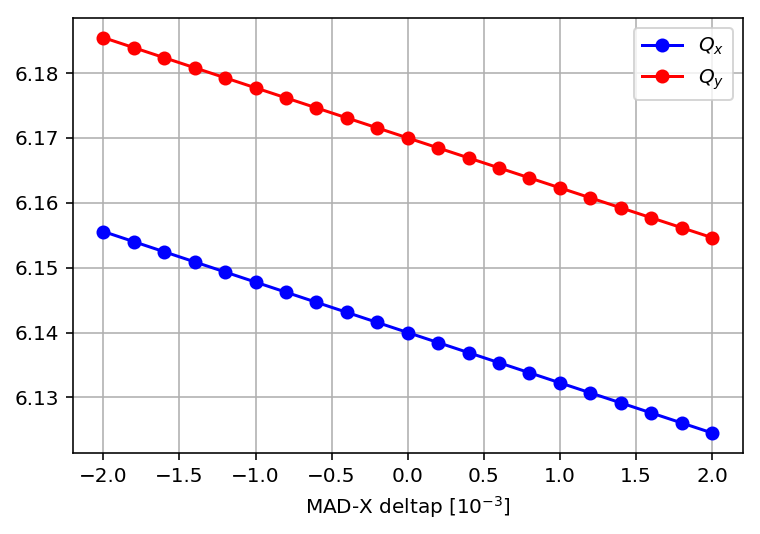

In [24]:
plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q1,'o-b', label='$Q_x$')
plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q2,'o-r', label='$Q_y$')
plt.xlabel('MAD-X deltap [$10^{-3}$]')
plt.grid()
plt.legend(loc='best');

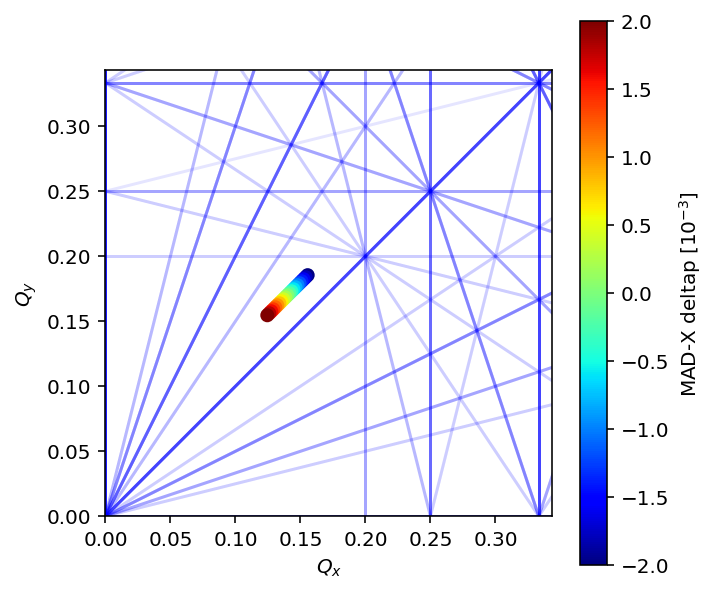

In [25]:
plotTuneDiagram()
Q1=madx.table.summ.q1
Q2=madx.table.summ.q2
plt.scatter(Q1-np.floor(Q1),Q2-np.floor(Q2),c=madx.table.summ.deltap*1000, cmap='jet');
plt.xlim(0,1/3+.01)
plt.ylim(0,1/3+.01)
myColorbar=plt.colorbar()
myColorbar.set_label('MAD-X deltap [$10^{-3}$]')

### Off-momentum $\beta$-beating
In addition to the different tunes, the off-momentum particle will be also present a off-momentum $\beta$-beating.

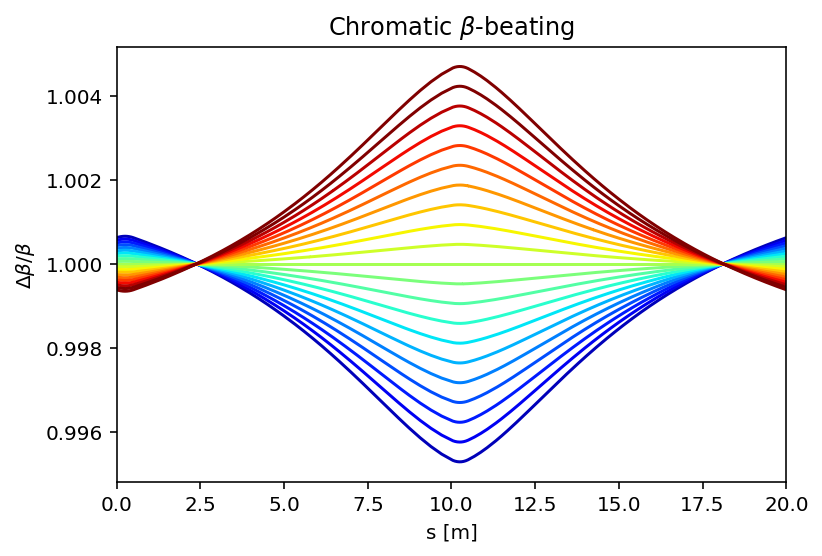

In [225]:
aux2=madx.table.twiss_11.dframe()
myColor=plt.cm.get_cmap('jet', 21)
for i in range(1,21):
    aux1=madx.table[f'twiss_{i}'].dframe()
    plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(i))
aux1=madx.table[f'twiss'].dframe()
plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('$\Delta \\beta/\\beta$')
plt.title('Chromatic $\\beta$-beating');

## Chromatic correction

Remembering that sextupole acts as quadrupoles on the dispersive closed orbit (feed-down) and assuming
that we have two sextupoles in $s_1$ and $s_2$,  then the linear response of chromaticity $(\Delta\xi_x,~\Delta\xi_y)^T$ with respect to the sextupoles integrated gradients $(k2l(s_1),~k2l(s_2))^T$ is 

\begin{equation}
\begin{pmatrix}
\Delta\xi_x \\ 
\Delta\xi_y
\end{pmatrix}=\underbrace{\frac{1}{4\pi}
\begin{pmatrix}
\beta_x(s_1) D_x(s_1) & \beta_x(s_2) D_x(s_2)  \\ 
-\beta_y(s_1) D_x(s_1) & -\beta_y(s_2) D_x(s_2)
\end{pmatrix}}_{R_{k2l\rightarrow \Delta\xi}}
\begin{pmatrix}
k2l(s_1) \\ 
k2l(s_2)
\end{pmatrix}.
\end{equation}

We can determine the value of $(k2l(s_1),~k2l(s_2))^T$ by inverting this problem after having chosen $s_1$ and $s_2$.

In [26]:
madx.input('''
ksf=0;
ksd=0;
twiss;''')
twissSextupolesOFF=madx.table.twiss.dframe()
showChroma()

DQ1 = -8.49531
DQ2 = -8.5981


In [27]:
madx.input('twiss;')
import numpy as np
twissSextupolesOFF=madx.table.twiss.dframe()
dq1=madx.table.summ.dq1[0]
dq2=madx.table.summ.dq2[0]
aux=twissSextupolesOFF[twissSextupolesOFF['name']=='msf:1']
bx1=aux['betx'].values[0]
by1=aux['bety'].values[0]
dx1=aux['dx'].values[0]

aux=twissSextupolesOFF[twissSextupolesOFF['name']=='msd:1']
bx2=aux['betx'].values[0]
by2=aux['bety'].values[0]
dx2=aux['dx'].values[0]

####### Solution of the linear problem #######
M=np.array([[bx1*dx1, bx2*dx2],[-by1*dx1, -by2*dx2]])/4./np.pi
mySolution=np.linalg.inv(M)@np.array([[-dq1],[-dq2]])
print('=======================================')
print('This is the solution our matrix of the\nintegrated sextupoles strength:')
display(mySolution)
print('=======================================')
# Clearly it has to be divided (shared) by the number of the cells

This is the solution our matrix of the
integrated sextupoles strength:


array([[ 1.05385015],
       [-2.11942293]])

In [28]:
madx.input(f'''
! FROM the analytical approach
ksf={mySolution[0][0]}/ncell;
ksd={mySolution[1][0]}/ncell;
twiss;
''');
showChroma()

DQ1 = 3.1922e-14
DQ2 = 6.35162e-14


In [9]:
#to compare with MAD-X matching 
madx.input('''
! Matching
match, sequence=cas19;
  vary,name=ksf, step=0.00001;
  vary,name=ksd, step=0.00001;
  global,DQ1=0.0;
  global,DQ2=0.0;
  Lmdif, calls=100, tolerance=1.0e-40;
endmatch;

!execute the TWISS command 
twiss;
''')
showChroma()

DQ1 = 9.35644e-15
DQ2 = 1.00819e-15


In [13]:
aux=beamFB['deltap_p']
madx.input(f'twiss, deltap={-aux}:{aux+0.0002}:0.0002;');

The second order chromaticity is not corrected.

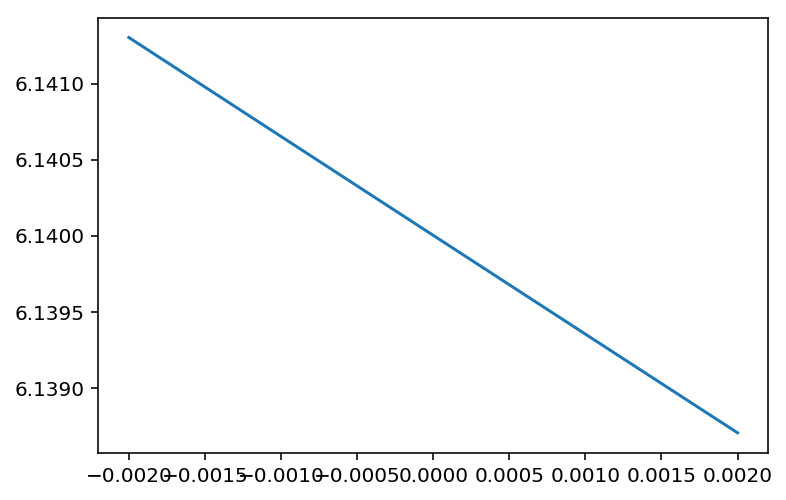

In [14]:
aux=madx.table.summ.dframe()
#plt.plot(aux['deltap'],aux['dq1'])
plt.plot(aux['deltap'],aux['q1'])

In [57]:
madx.table.summ.dframe()[['deltap','dq1','q1','dq2','q2']]

,deltap,dq1,q1,dq2,q2
#e,-2.000000e-03,2.162302e-03,6.139997,-1.454847e-02,6.170012
#e,-1.800000e-03,1.945198e-03,6.139998,-1.308782e-02,6.170010
#e,-1.600000e-03,1.728289e-03,6.139998,-1.162846e-02,6.170008
#e,-1.400000e-03,1.511575e-03,6.139999,-1.017039e-02,6.170006
#e,-1.200000e-03,1.295054e-03,6.139999,-8.713618e-03,6.170004
#e,-1.000000e-03,1.078727e-03,6.139999,-7.258133e-03,6.170003
#e,-8.000000e-04,8.625947e-04,6.140000,-5.803935e-03,6.170002
#e,-6.000000e-04,6.466558e-04,6.140000,-4.351025e-03,6.170001
#e,-4.000000e-04,4.309104e-04,6.140000,-2.899400e-03,6.170000
#e,-2.000000e-04,2.153585e-04,6.140000,-1.449058e-03,6.170000


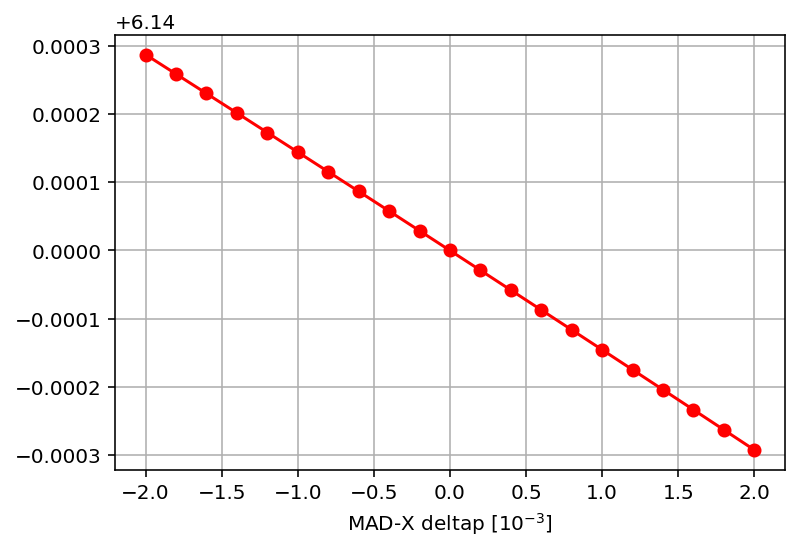

In [41]:
#The non-linear vertical chromaticity is Very clear
plt.plot(madx.table.summ.deltap*1000,madx.table.summ.q1,'o-r', label='$Q_x$')
plt.xlabel('MAD-X deltap [$10^{-3}$]')
plt.grid()

The chromaticity reduction improved significantly also the chromatic $\beta$-beating. In fact,

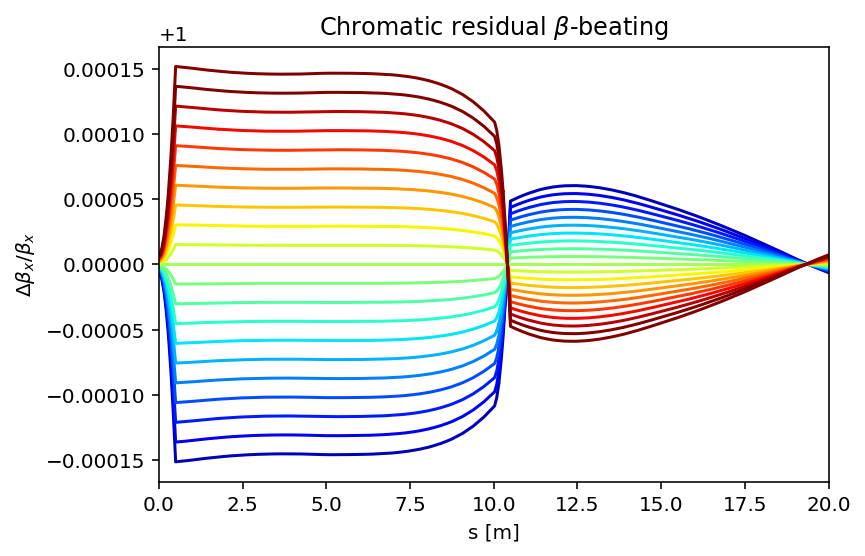

In [234]:
aux2=madx.table.twiss_11.dframe()
myColor=plt.cm.get_cmap('jet', 21)
for i in range(1,21):
    aux1=madx.table[f'twiss_{i}'].dframe()
    plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(i))
    #plt.plot(aux.s, aux1.bety/aux2.bety,'r:')
aux1=madx.table[f'twiss'].dframe()
plt.plot(aux1.s, aux1.betx/aux2.betx,color=myColor(21))
plt.xlim(0,lcell_m)
plt.xlabel('s [m]')
plt.ylabel('$\Delta \\beta_x/\\beta_x$')
plt.title('Chromatic residual $\\beta$-beating');

Therefore if we plot again the Q-diagram, after the chromaticity correction, we have the following result:

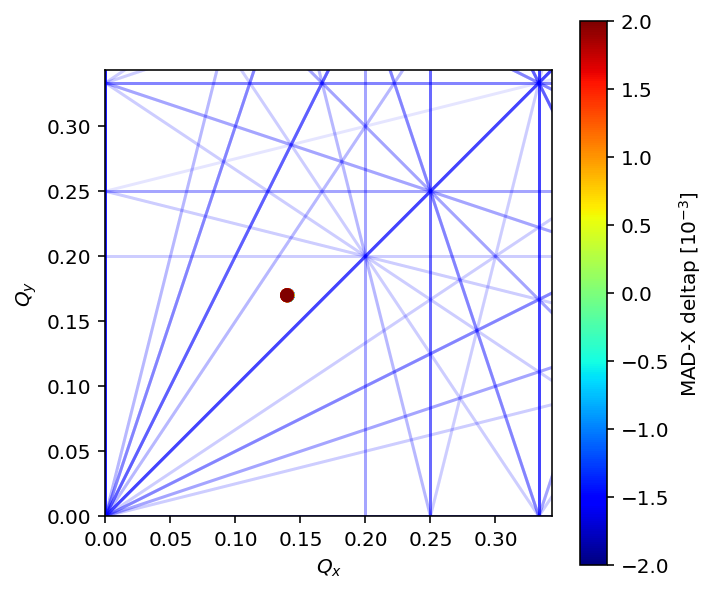

In [235]:
plotTuneDiagram()
Q1=madx.table.summ.q1
Q2=madx.table.summ.q2
plt.get_cmap('jet')
plt.scatter(Q1-np.floor(Q1),Q2-np.floor(Q2),c=madx.table.summ.deltap*1000, cmap='jet');
plt.xlim(0,1/3+.01)
plt.ylim(0,1/3+.01)
myColorbar=plt.colorbar()
myColorbar.set_label('MAD-X deltap [$10^{-3}$]')

### But now the system is NOT linear anymore...
We trade-off the off-momentum detunign with som amplitude detuning. To explore the amplitude detuning we compute the so-called tune fooprint.

In [237]:
myNumberOfTurns = 1024

# MAD-X macro
myFootMacro = '''
MAKEFOOTPRINT(namestudy):macro={
small=0.02;
big=sqrt(1.-small^2);
track;
xs=small;
ys=small;
value,xs,ys;
start,fx=xs,fy=ys;
n=1;
m=0;
while (n <= 6)
{
angle = 15*m*pi/180;
if (m == 0) {xs=n*big; ys=n*small;}
elseif (m == 6) {xs=n*small; ys=n*big;}
else
{
xs=n*cos(angle);
ys=n*sin(angle);
}
value,xs,ys;
start,fx=xs,fy=ys;
m=m+1;
if (m == 7) { m=0; n=n+1;}
};
dynap,fastune,turns='''+str(myNumberOfTurns)+''';
run, turns=1024;
endtrack;
write,table=dynap;
write,table=dynaptune;
};
''' 
madx.input(myFootMacro);
madx.input('''
exec, MAKEFOOTPRINT(myteststudy);
''');

These are the initial condition of the tracked particles for determing  the tune footprint.

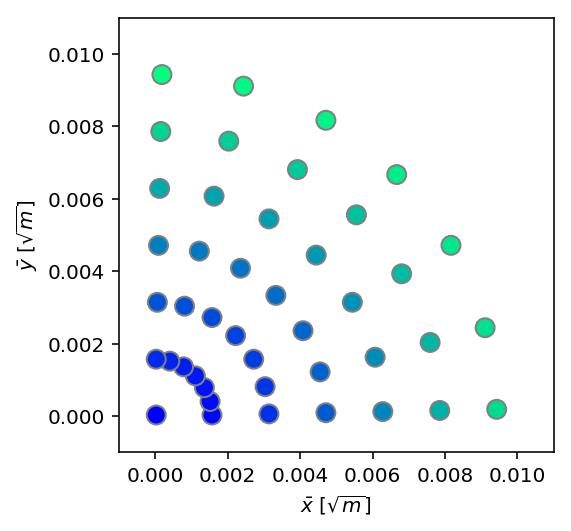

In [239]:
beta=madx.table.twiss.betx[0]
alpha=madx.table.twiss.alfx[0]
PX=np.array([[np.sqrt(beta), 0],[-alpha/np.sqrt(beta), 1/np.sqrt(beta)]])

beta=madx.table.twiss.bety[0]
alpha=madx.table.twiss.alfy[0]
PY=np.array([[np.sqrt(beta), 0],[-alpha/np.sqrt(beta), 1/np.sqrt(beta)]])


aux=madx.table['tracksumm'].dframe()
barX=[]
barY=[]

for i in range(int(len(aux)/2)):
    myTable=aux.iloc[i]
    X= np.array([myTable['x'],myTable['px']])
    Y= np.array([myTable['y'],myTable['py']])
    barX.append(np.linalg.inv(PX)@X)
    barY.append(np.linalg.inv(PY)@Y)

barX=np.array(barX).transpose()
barY=np.array(barY).transpose()
plt.scatter(barX[0,:],barY[0,:],c=np.arange(len(barX[0,:])),cmap='winter', s=90,edgecolor='gray')
plt.axis('square');
plt.xlabel('$\\bar{x}$ [$\sqrt{m}$]')
plt.ylabel('$\\bar{y}$ [$\sqrt{m}$]');
plt.xlim([-0.001,.011])
plt.ylim([-0.001,.011]);

So we are regularly sampling the $\{\bar{x},\bar{y}\}$ normalized-plane. And this is the equivalent tune foorprint.

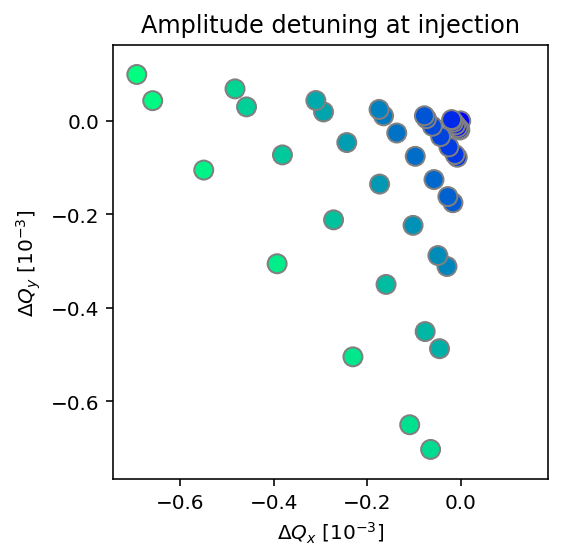

In [240]:
madx.input('twiss;')
myFootPrintDF = madx.table.dynaptune.dframe()
q1=madx.table.summ.q1-np.round(madx.table.summ.q1)
q2=madx.table.summ.q2-np.round(madx.table.summ.q2)

plt.scatter((myFootPrintDF.tunx.values-q1)*1e3,(myFootPrintDF.tuny.values-q2)*1e3,\
            c=np.arange(len(barX[0,:])),cmap='winter', s=90,edgecolor='gray')
plt.xlabel('$\Delta Q_x\ [10^{-3}]$')
plt.ylabel('$\Delta Q_y\ [10^{-3}]$');
plt.axis('square')
plt.title('Amplitude detuning at injection');

### Extracting second order maps from MAD-X
Yes. See the **sectormap** command 
http://madx.web.cern.ch/madx/webguide/manual.html#Ch29

In [241]:
madx.input('select,flag=interpolate,clear;twiss,sectormap;');

In [242]:
sectormapDF=madx.table.sectortable.dframe()
sectormapDF.head()

,name,pos,k1,k2,k3,k4,k5,k6,r11,r21,...,t356,t456,t556,t656,t166,t266,t366,t466,t566,t666
#s,cas19$start,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
start_machine,start_machine,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
drift_0[0],drift_0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.011333,0.0
qf..1,qf..1,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.017457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
drift_1[0],drift_1,0.091270,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.025903,0.0


In the previous dataframe you can see for the different elements the maps 
\begin{equation}
\boxed{
x_i(s_1)=\underbrace{k_i}_{0-order}+ \underbrace{\sum_j r_{ij}\ x_j(s_0)}_{1-order} + \underbrace{\sum_j\sum_k t_{ijk}\ x_j(s_0)x_k(s_0)}_{2-order}
}
\end{equation}
where $k_i$,$r_{ij}$ and $t_{ijk}$ can be found in the **sectormap** dataframe. The $x_i$ are the 6 phase coordinates (in MAD-X are (x,px,y,py,t,pt)) in $s_0$ and $s_1$.

In [243]:
# We select the non vanishing terms of the zero, first and second-order maps
aux=sectormapDF[sectormapDF.index=='msf'].transpose()
aux[aux['msf']!=0]

,msf
name,msf
pos,0.500005
r11,1
r22,1
r33,1
r44,1
r55,1
r66,1
t211,-0.021077
t431,0.021077


For this thin sextupole and for the x-plane, that 
\begin{eqnarray}
x_1&=&x_0\\
px_1&=&px_0+ g\times (x_0^2 - y_0^2)
\end{eqnarray}
where the indexes 0 and 1 refer, respectively, to the entry and exit of the sextupole (it is thin since $x_1=x_0$).

This is one of the simplest non-linear map we can image. Its systematic study has been carried out by Michel Hénon (1931-2013, https://en.wikipedia.org/wiki/Michel_H%C3%A9non ). The simplest version of the Hénon map assumes 1D motion and decomposes the motion of the particle in a pure rotation and a thin sextupolar kick 
\begin{equation}
\begin{pmatrix}
x_{n+1}\\
px_{n+1}
\end{pmatrix}
=
\begin{pmatrix}
\cos\mu_x\quad \sin\mu_x\\
-\sin\mu_x\quad \cos\mu_x
\end{pmatrix}
\begin{pmatrix}
x_{n}\\
px_{n}
\end{pmatrix}+
g\begin{pmatrix}
0\\
x_n^2
\end{pmatrix}
\end{equation}

In [244]:
from ipywidgets import interactive
import warnings
warnings.filterwarnings('ignore')
# Q is the tune
# a and phi0 are the max amplitude and the phase of the turn=0 points
# Nturns is the turn number
# g is proportional to the sextupole gradient
# the code solve the simple Hénon map
# x[n+1] = x[n]
# xp[n+1]= xp[n]+g*x[n]^2
# and after I apply a pure rotation of Q
Q=1/4+.001
a=.05
Nturns=1000
Namplitude=20
g=-23
def henonMap(Q, phi0,a,g,Nturns,Namplitude):
    phi_rad=np.pi/180.*phi0
    phi=2*np.pi*Q
    R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])
    for j in np.linspace(0,a,Namplitude): 
        X=[]
        A=R0 @ np.array([[j],[0]])
        X.append(A )
        for i in range(Nturns):
            X.append(R @ (X[i]+g*np.array([[0],[X[i][0]*X[i][0]]])))
        plt.plot(np.array(X)[:,0],np.array(X)[:,1],'.', ms=1)

    plt.axis('square');
    plt.xlabel('$\\bar{x}$ [arb. units]')
    plt.ylabel('$\\bar{px}$ [arb. units]')
    plt.xlim(-a,a)
    plt.ylim(-a,a);
    plt.title('Q='+str(Q)+
              ', phi0='+str(phi0)+
              ', a='+str(a)+
              ', g='+str(g))
interactive_plot = interactive(henonMap, Q=(0.0, 1.0, 0.001), phi0=(0, 360, 1), a=(0, .1, .0001),g=(-50,50,1),Nturns=(0,2000,1),Namplitude=(10,50,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.5, description='Q', max=1.0, step=0.001), IntSlider(value=180, descr…

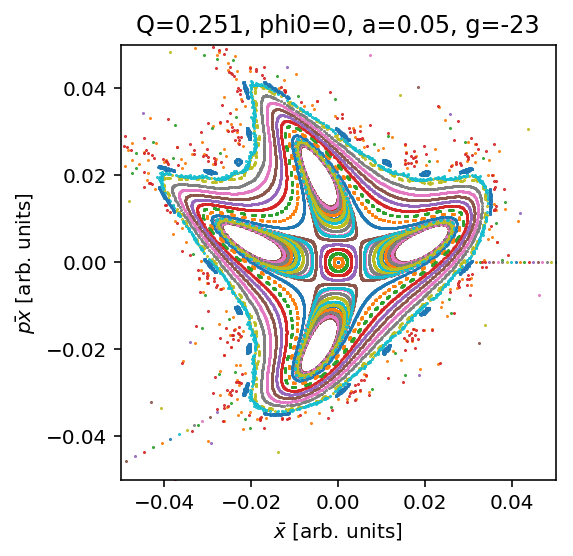

In [246]:
# An example
henonMap(Q=1/4+.001, phi0=0,a=.05,g=-23,Nturns=1000,Namplitude=50)

### Dynamic aperture
Can define a scalar observable to take into accound the evolotion of this phase portrait? Indeed several observables can be defined. We will concentrate on the evolution of $\sqrt{\bar{x}^2+\bar{px}^2}/2$.

In [247]:
import pandas as pd
Q=1/4+.001
a=.05
Nturns=1000
Namplitude=50
g=-23
phi0=0
def DAStudies(Q, phi0,a,g,Nturns,Namplitude):
    aux=pd.DataFrame()
    phi_rad=np.pi/180.*phi0
    
    phi=2*np.pi*Q

    R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])

    for j in np.linspace(0,a,Namplitude): 
        X=[]
        Amplitude=[]
        A=R0 @ np.array([[j],[0]])
        X.append(A)
        Amplitude.append(np.sqrt(A[0]**2+A[1]**2)/2)
        for i in range(Nturns):
            X.append(R @ (X[i]+g*np.array([[0],[X[i][0]*X[i][0]]])))
            Amplitude.append(np.sqrt(X[i+1][0]**2+X[i+1][1]**2)/2)
        aux=pd.concat([aux,pd.DataFrame(np.array(Amplitude),columns=[j])], axis=1, sort=False)

    return aux
aux=DAStudies(Q, phi0,a,g,Nturns,Namplitude)

In [248]:
def DAStudiesVsTurns(Nturns):
    plt.plot(np.linspace(0,a,Namplitude),aux[0:Nturns].max(),'ok')
    plt.ylim(0,.05)
    plt.xlim(0,.05)
    plt.grid()
    plt.xlabel('$\\bar{x}_0$ [arb. units]')
    plt.ylabel('$\max_{Nturns}(\\sqrt{\\bar{x}^2+\\bar{px}^2}/2)$ [arb. units]')

interactive_plot = interactive(DAStudiesVsTurns,Nturns=(1,2000,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=1000, description='Nturns', max=2000, min=1), Output(layout=Layout(heigh…

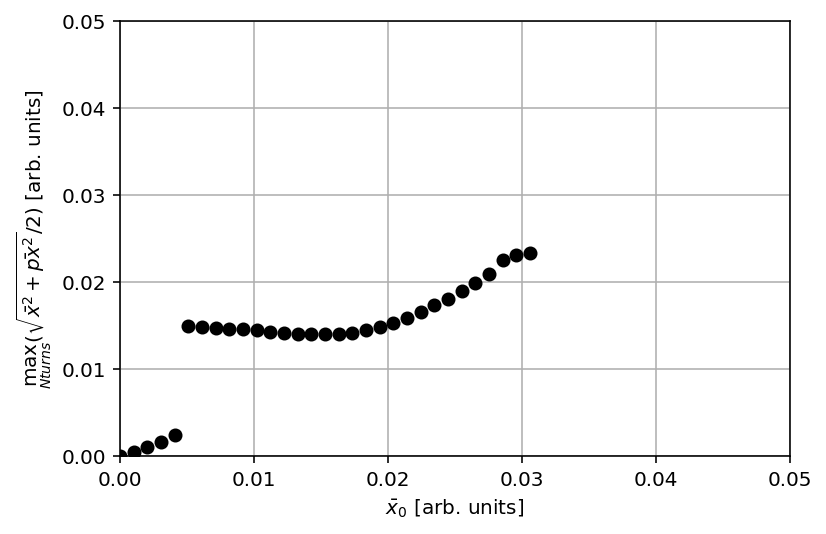

In [249]:
# An example
DAStudiesVsTurns(1000)

## Frequency locking mechanism
We can also study the frequency of the single particles and consider as function of the initial amplitude.

In [250]:
Q=1/4+.001
a=.028
Nturns=5000
Namplitude=200
g=-23
def amplitudeDetuning(Q, phi0,a,g,Nturns,Namplitude):
    aux=pd.DataFrame()
    phi_rad=np.pi/180.*phi0   
    phi=2*np.pi*Q
    R=np.array([[np.cos(phi),np.sin(phi)],[-np.sin(phi),np.cos(phi)]])
    R0=np.array([[np.cos(phi_rad),np.sin(phi_rad)],[-np.sin(phi_rad),np.cos(phi_rad)]])
    for j in np.linspace(0,a,Namplitude): 
        X=[]
        Amplitude=[]
        A=R0 @ np.array([[j],[0]])
        X.append(A)
        Amplitude.append(np.sqrt(A[0]**2+A[1]**2)/2)
        for i in range(Nturns):
            X.append(R @ (X[i]+g*np.array([[0],[X[i][0]*X[i][0]]])))
            Amplitude.append(X[i+1][0])
        aux=pd.concat([aux,pd.DataFrame(np.array(Amplitude),columns=[j])], axis=1, sort=False)
    return aux
aux=amplitudeDetuning(Q, phi0,a,g,Nturns,Namplitude)

import PyNAFF as pnf


myQ=[]
for i in range(Namplitude)[1:]:
    signal = aux[aux.columns[i]].values;
    pnf.naff(signal, 500, 1, 0 , False, window=1)
    # outputs an array of arrays for each frequency. Each sub-array includes:
    # [order of harmonic, frequency, Amplitude, Re{Amplitude}, Im{Amplitude]

    # My frequency is simply 
    myQ.append(pnf.naff(signal, 5000, 1, 0 , False)[0][1])

In [251]:
def amplitudeDetuningVsTurns(Nturns):
    myQ=[]
    for i in range(Namplitude)[1:]:
        signal = aux[aux.columns[i]].values;
        myQ.append(pnf.naff(signal, Nturns, 1, 0 , False)[0][1])
    plt.plot(np.linspace(0,a,Namplitude)[1:],myQ,'k.-')
    myX=np.linspace(0,a,Namplitude)[1:]
    plt.plot(myX,Q*np.ones_like(myX),'-.r')
    plt.grid()
    plt.xlim(0,0.05)
    plt.ylabel('$Q_x$')
    plt.xlabel('$\\bar{x}_0$ [arb. units]')

interactive_plot = interactive(amplitudeDetuningVsTurns,Nturns=(10,5000,1),continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot


interactive(children=(IntSlider(value=2505, description='Nturns', max=5000, min=10), Output(layout=Layout(heig…

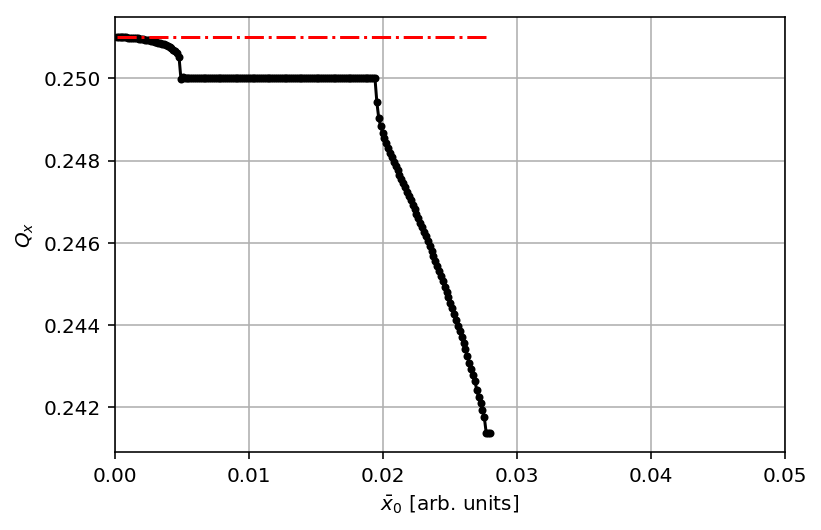

In [252]:
# An example
amplitudeDetuningVsTurns(2500)

### Thanks for your attention.